### Standard LSTM Model with Optuna Bayesian Tuning + TimeSeries K-Fold CV

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import lime.lime_tabular
import shap
import optuna
from IPython.display import display, HTML

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
DATA_PATH = '/Users/amalshar/Desktop/USD/Fall 2025/Data Analysis/Final Project/daily_2025_cleaned_data.csv'
FEATURES = ['CO', 'SO2', 'NO2', 'O3', 'PM25',
            'BarometricPressure', 'Temperature', 'WindResultant']
TARGET = 'DailyAQI'
TIME_STEPS = 7

# Load
df = pd.read_csv(DATA_PATH)

X_raw = df[FEATURES].values
y_raw = df[TARGET].values.reshape(-1, 1)

In [4]:
# Scale
scaler_X = MinMaxScaler().fit(X_raw)
scaler_y = MinMaxScaler().fit(y_raw)
X_scaled = scaler_X.transform(X_raw)
y_scaled = scaler_y.transform(y_raw)

In [5]:
# Sequence builder
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)
print("X_seq shape:", X_seq.shape, " y_seq shape:", y_seq.shape)

X_seq shape: (94124, 7, 8)  y_seq shape: (94124, 1)


In [6]:
# Hold-out test split AFTER tuning 
split_idx = int(0.8 * len(X_seq))
X_all_train, y_all_train = X_seq[:split_idx], y_seq[:split_idx]
X_test,       y_test     = X_seq[split_idx:], y_seq[split_idx:]

print("Train for tuning:", X_all_train.shape, " Test:", X_test.shape)

Train for tuning: (75299, 7, 8)  Test: (18825, 7, 8)


In [7]:
def build_lstm_model(n_units1=64, n_units2=64, dropout1=0.0, dropout2=0.0, lr=1e-3):
    model = Sequential([
        Input(shape=(TIME_STEPS, len(FEATURES))),
        LSTM(n_units1, activation='relu', return_sequences=True),
        BatchNormalization(),
        Dropout(dropout1),
        LSTM(n_units2, activation='relu'),
        BatchNormalization(),
        Dropout(dropout2),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['mae'])
    return model

In [8]:
def objective(trial):
    # Search space
    n_units1 = trial.suggest_int('n_units1', 32, 128, step=32)
    n_units2 = trial.suggest_int('n_units2', 32, 128, step=32)
    dropout1 = trial.suggest_float('dropout1', 0.0, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.0, 0.5)
    lr       = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_sz = trial.suggest_categorical('batch_size', [32, 64, 128])

    # K-fold CV on the training portion only (leak-free, ordered)
    tscv = TimeSeriesSplit(n_splits=5)
    fold_losses = []

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_all_train)):
        X_tr, X_val = X_all_train[tr_idx], X_all_train[val_idx]
        y_tr, y_val = y_all_train[tr_idx], y_all_train[val_idx]

        model = build_lstm_model(n_units1, n_units2, dropout1, dropout2, lr)

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)
        ]

        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=150,
            batch_size=batch_sz,
            verbose=0,
            callbacks=callbacks
        )

        # Use best val_loss this fold
        val_loss = min(history.history['val_loss'])
        fold_losses.append(val_loss)

        # Prune if not promising
        trial.report(np.mean(fold_losses), fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return float(np.mean(fold_losses))


In [9]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, show_progress_bar=False)
print("Best trial:", study.best_trial.number)
print("Best params:", study.best_params)
print("Best CV val_loss:", study.best_value)

best_params = study.best_params

[I 2025-11-05 11:33:39,005] A new study created in memory with name: no-name-bb896d29-2c2a-45c8-9939-f37187ff2ac8
[I 2025-11-05 12:00:12,542] Trial 0 finished with value: 0.000992139842128381 and parameters: {'n_units1': 128, 'n_units2': 64, 'dropout1': 0.4651839800697645, 'dropout2': 0.18907769647159045, 'lr': 0.008515566401850002, 'batch_size': 32}. Best is trial 0 with value: 0.000992139842128381.
[I 2025-11-05 12:14:40,707] Trial 1 finished with value: 0.0009526396956061944 and parameters: {'n_units1': 64, 'n_units2': 32, 'dropout1': 0.017708247340300298, 'dropout2': 0.3895403755952516, 'lr': 0.0018220222186287537, 'batch_size': 32}. Best is trial 1 with value: 0.0009526396956061944.
[I 2025-11-05 12:39:31,724] Trial 2 finished with value: 0.0009673650783952326 and parameters: {'n_units1': 96, 'n_units2': 128, 'dropout1': 0.24338441788395682, 'dropout2': 0.0297737616036039, 'lr': 0.00022856244724903213, 'batch_size': 32}. Best is trial 1 with value: 0.0009526396956061944.
[I 2025-1

Best trial: 1
Best params: {'n_units1': 64, 'n_units2': 32, 'dropout1': 0.017708247340300298, 'dropout2': 0.3895403755952516, 'lr': 0.0018220222186287537, 'batch_size': 32}
Best CV val_loss: 0.0009526396956061944


In [10]:
final_model = build_lstm_model(
    n_units1=best_params['n_units1'],
    n_units2=best_params['n_units2'],
    dropout1=best_params['dropout1'],
    dropout2=best_params['dropout2'],
    lr=best_params['lr']
)

final_callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-5, verbose=1)
]

In [11]:
history = final_model.fit(
    X_all_train, y_all_train,
    validation_split=0.2,
    epochs=200,
    batch_size=best_params['batch_size'],
    callbacks=final_callbacks,
    verbose=1
)

Epoch 1/200
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0309 - mae: 0.0549 - val_loss: 9.1190e-04 - val_mae: 0.0116 - learning_rate: 0.0018
Epoch 2/200
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0011 - mae: 0.0164 - val_loss: 0.0011 - val_mae: 0.0200 - learning_rate: 0.0018
Epoch 3/200
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0011 - mae: 0.0165 - val_loss: 9.0602e-04 - val_mae: 0.0107 - learning_rate: 0.0018
Epoch 4/200
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0011 - mae: 0.0165 - val_loss: 9.1736e-04 - val_mae: 0.0108 - learning_rate: 0.0018
Epoch 5/200
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0011 - mae: 0.0162 - val_loss: 0.0018 - val_mae: 0.0339 - learning_rate: 0.0018
Epoch 6/200
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0011 - mae: 0.0159 - val_loss: 9.9024e-04 - val_mae: 0.0135 - learning_rate: 0.0018
Epoch 7/200
1871/1883 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - mae: 0.0157
Epoch 7: ReduceLROnPlateau re

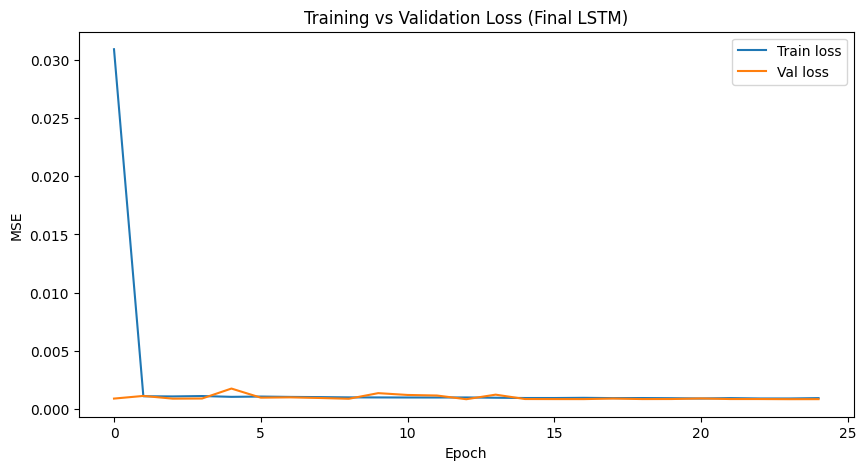

In [12]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss (Final LSTM)')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.legend(); plt.show()

In [13]:
y_pred_scaled = final_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)


589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [14]:
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-6))) * 100
r2   = r2_score(y_true, y_pred)

print(f"\nFinal Test Metrics with Tuned LSTM")
print(f"MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")



Final Test Metrics with Tuned LSTM
MSE: 742.070 | RMSE: 27.241 | MAE: 17.186 | MAPE: 4328969.71% | R²: 0.050


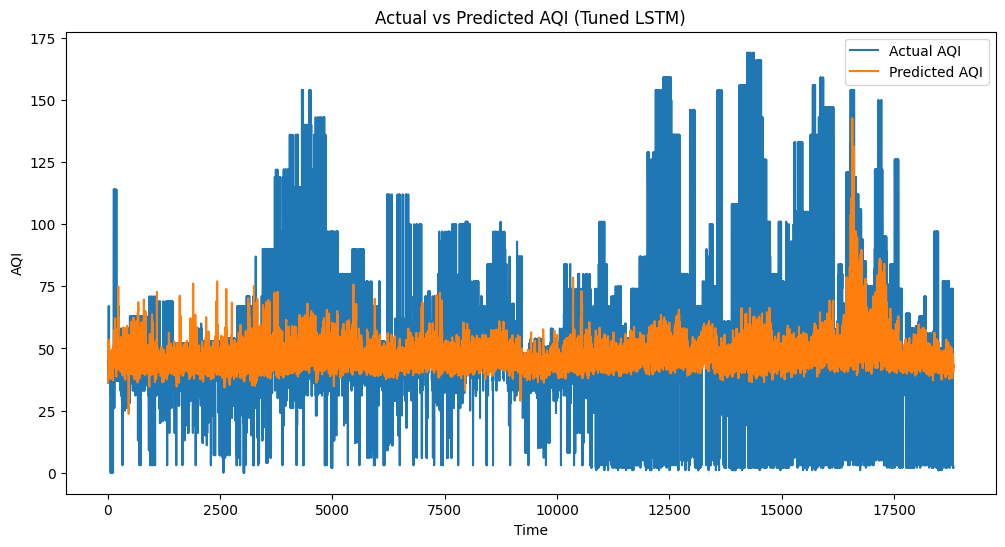

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_true, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.title('Actual vs Predicted AQI (Tuned LSTM)')
plt.xlabel('Time'); plt.ylabel('AQI'); plt.legend(); plt.show()

In [16]:
def permutation_importance_lstm(model, Xtest, ytrue, n_repeats=3, metric=r2_score):
    base = scaler_y.inverse_transform(model.predict(Xtest))
    base_score = metric(scaler_y.inverse_transform(ytrue), base)
    scores = {f: [] for f in FEATURES}

    for j, f in enumerate(FEATURES):
        for _ in range(n_repeats):
            Xp = Xtest.copy()
            perm = np.random.permutation(Xp.shape[0])
            Xp[:, :, j] = Xp[perm, :, j]
            pred = scaler_y.inverse_transform(model.predict(Xp))
            scores[f].append(base_score - metric(scaler_y.inverse_transform(ytrue), pred))
    return {k: float(np.mean(v)) for k, v in scores.items()}

feat_imp = permutation_importance_lstm(final_model, X_test, y_test)
imp_df = pd.DataFrame(sorted(feat_imp.items(), key=lambda x: x[1], reverse=True),
                      columns=['Feature','Importance'])
print("\nPermutation Importance (R² drop):\n", imp_df)

589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step
589/589 ━━━━━━

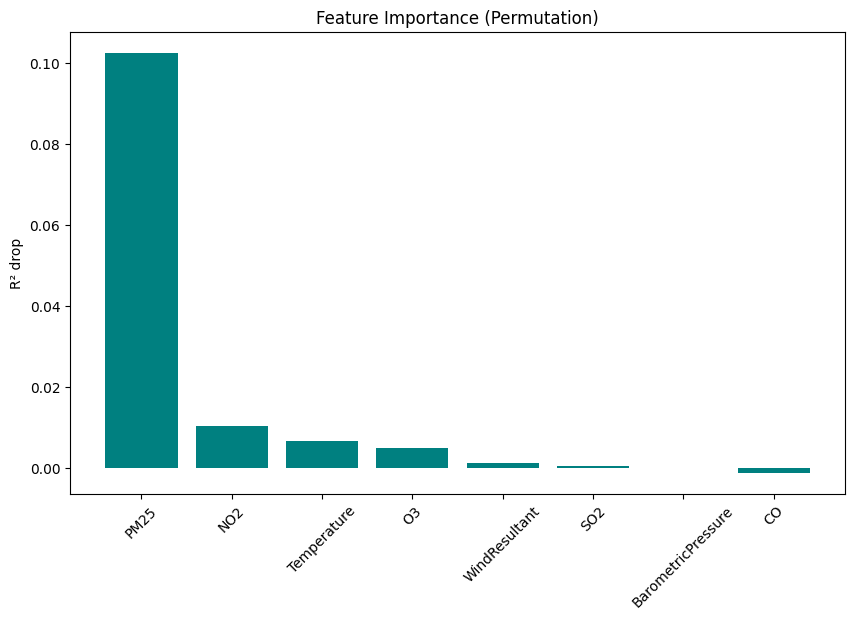

In [17]:
plt.figure(figsize=(10,6))
plt.bar(imp_df['Feature'], imp_df['Importance'], color='teal')
plt.xticks(rotation=45); plt.ylabel('R² drop'); plt.title('Feature Importance (Permutation)'); plt.show()


In [18]:
X_train_flat = X_all_train.reshape(X_all_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)
feature_names_flat = [f"{feat}_t-{t}" for t in range(TIME_STEPS) for feat in FEATURES]

def predict_wrapper(flat_input):
    reshaped = flat_input.reshape(-1, TIME_STEPS, len(FEATURES))
    return final_model.predict(reshaped).flatten()

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names_flat,
    mode='regression'
)

i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10
)

try:
    exp.show_in_notebook(show_table=True)
except Exception:
    display(HTML(exp.as_html()))

with open("exp7_lime_expalanation.html", "w") as f:
    f.write(exp.as_html())


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step


 10%|█         | 1/10 [00:00<00:07,  1.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 20%|██        | 2/10 [00:01<00:06,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 30%|███       | 3/10 [00:02<00:05,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 40%|████      | 4/10 [00:03<00:05,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 50%|█████     | 5/10 [00:04<00:04,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 60%|██████    | 6/10 [00:05<00:03,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 70%|███████   | 7/10 [00:06<00:02,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 80%|████████  | 8/10 [00:06<00:01,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 90%|█████████ | 9/10 [00:07<00:00,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


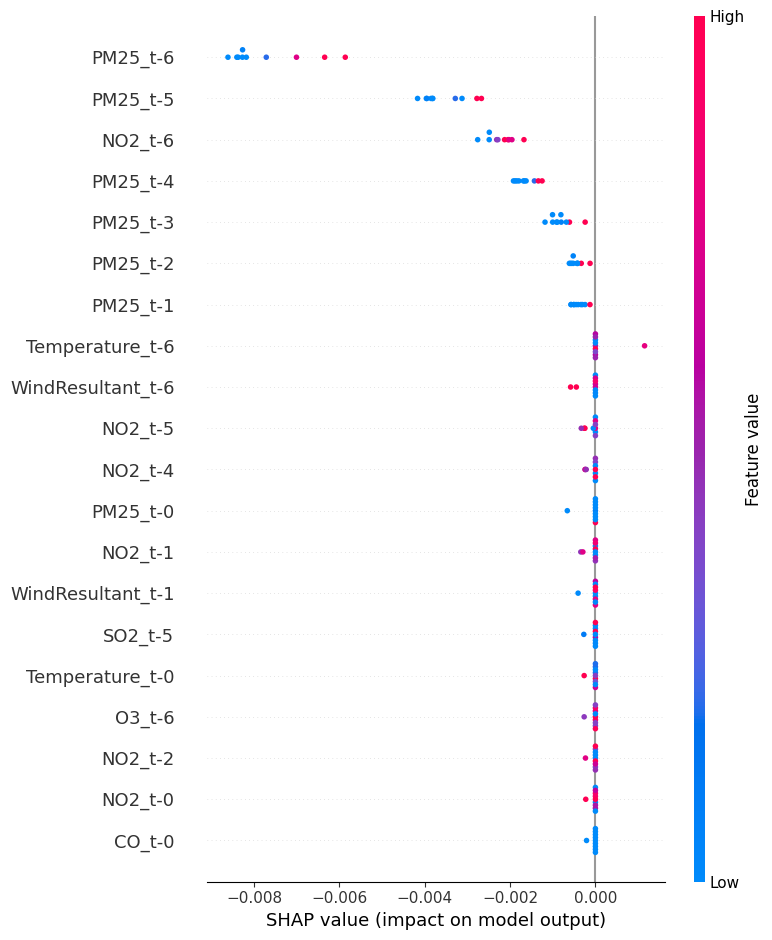

In [19]:
background = X_train_flat[:100]
test_samples = X_test_flat[:10]

shap_explainer = shap.KernelExplainer(predict_wrapper, background)
shap_values = shap_explainer.shap_values(test_samples, nsamples=200)

shap.summary_plot(shap_values, test_samples, feature_names=feature_names_flat)